In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools 

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('euro_exchange_rate.csv')
df.head()

,Date,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
0,2023-03-23,1.0879,142.87,1.9558,NaN,23.658,7.4482,NaN,0.88523,384.75,...,89.4810,1396.18,20.1915,4.8063,1.7373,59.125,1.4434,37.119,19.7787,NaN
1,2023-03-22,1.0785,143.13,1.9558,NaN,23.722,7.4472,NaN,0.87925,388.55,...,89.0800,1406.43,20.0036,4.8047,1.7362,58.683,1.4391,37.100,19.8529,NaN
2,2023-03-21,1.0776,142.63,1.9558,NaN,23.846,7.4465,NaN,0.88033,391.58,...,89.0308,1406.34,20.1454,4.8196,1.7412,58.485,1.4392,36.929,19.9659,NaN
3,2023-03-20,1.0717,140.77,1.9558,NaN,23.988,7.4450,NaN,0.87560,399.21,...,88.4900,1401.82,20.3003,4.8076,1.7106,58.281,1.4354,36.513,19.7861,NaN
4,2023-03-17,1.0623,140.57,1.9558,NaN,23.948,7.4450,NaN,0.87488,395.93,...,87.7870,1389.84,19.9829,4.7649,1.7014,58.118,1.4262,36.246,19.4988,NaN


In [3]:
df=df.drop('Unnamed: 42', axis=1)
df.columns

Index(['Date', 'USD', 'JPY', 'BGN', 'CYP', 'CZK', 'DKK', 'EEK', 'GBP', 'HUF',
       'LTL', 'LVL', 'MTL', 'PLN', 'ROL', 'RON', 'SEK', 'SIT', 'SKK', 'CHF',
       'ISK', 'NOK', 'HRK', 'RUB', 'TRL', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY',
       'HKD', 'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD',
       'THB', 'ZAR'],
      dtype='object')

In [4]:
df.isnull().sum()

Date       0
USD        0
JPY        0
BGN      398
CYP     3902
CZK        0
DKK        0
EEK     3132
GBP        0
HUF        0
LTL     2109
LVL     2364
MTL     3902
PLN        0
ROL     4542
RON     1664
SEK        0
SIT     4157
SKK     3646
CHF        0
ISK     2341
NOK        0
HRK     1658
RUB     1873
TRL     4669
TRY     1537
AUD        0
BRL     2304
CAD        0
CNY     1599
HKD        0
IDR     1599
ILS     3074
INR     2560
KRW        0
MXN     2304
MYR     1599
NZD        0
PHP     1599
SGD        0
THB     1599
ZAR        0
dtype: int64

Print full rows having NULL entries in the df

In [5]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [6]:
print(rows_with_NaN)

            Date     USD     JPY     BGN      CYP     CZK     DKK      EEK  \
0     2023-03-23  1.0879  142.87  1.9558      NaN  23.658  7.4482      NaN   
1     2023-03-22  1.0785  143.13  1.9558      NaN  23.722  7.4472      NaN   
2     2023-03-21  1.0776  142.63  1.9558      NaN  23.846  7.4465      NaN   
3     2023-03-20  1.0717  140.77  1.9558      NaN  23.988  7.4450      NaN   
4     2023-03-17  1.0623  140.57  1.9558      NaN  23.948  7.4450      NaN   
...          ...     ...     ...     ...      ...     ...     ...      ...   
6201  1999-01-08  1.1659  130.09     NaN  0.58187  34.938  7.4433  15.6466   
6202  1999-01-07  1.1632  129.43     NaN  0.58187  34.886  7.4431  15.6466   
6203  1999-01-06  1.1743  131.42     NaN  0.58200  34.850  7.4452  15.6466   
6204  1999-01-05  1.1790  130.96     NaN  0.58230  34.917  7.4495  15.6466   
6205  1999-01-04  1.1789  133.73     NaN  0.58231  35.107  7.4501  15.6466   

          GBP     HUF  ...     ILS      INR      KRW      MXN  

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6206 entries, 0 to 6205
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6206 non-null   datetime64[ns]
 1   USD     6206 non-null   float64       
 2   JPY     6206 non-null   float64       
 3   BGN     5808 non-null   float64       
 4   CYP     2304 non-null   float64       
 5   CZK     6206 non-null   float64       
 6   DKK     6206 non-null   float64       
 7   EEK     3074 non-null   float64       
 8   GBP     6206 non-null   float64       
 9   HUF     6206 non-null   float64       
 10  LTL     4097 non-null   float64       
 11  LVL     3842 non-null   float64       
 12  MTL     2304 non-null   float64       
 13  PLN     6206 non-null   float64       
 14  ROL     1664 non-null   float64       
 15  RON     4542 non-null   float64       
 16  SEK     6206 non-null   float64       
 17  SIT     2049 non-null   float64       
 18  SKK     

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6206 entries, 0 to 6205
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6206 non-null   datetime64[ns]
 1   USD     6206 non-null   float64       
 2   JPY     6206 non-null   float64       
 3   BGN     5808 non-null   float64       
 4   CYP     2304 non-null   float64       
 5   CZK     6206 non-null   float64       
 6   DKK     6206 non-null   float64       
 7   EEK     3074 non-null   float64       
 8   GBP     6206 non-null   float64       
 9   HUF     6206 non-null   float64       
 10  LTL     4097 non-null   float64       
 11  LVL     3842 non-null   float64       
 12  MTL     2304 non-null   float64       
 13  PLN     6206 non-null   float64       
 14  ROL     1664 non-null   float64       
 15  RON     4542 non-null   float64       
 16  SEK     6206 non-null   float64       
 17  SIT     2049 non-null   float64       
 18  SKK     

In [9]:
df5=df.loc[:,['Date','USD', 'JPY', 'GBP', 'AUD', 'CAD']]
df5.head()

,Date,USD,JPY,GBP,AUD,CAD
0,2023-03-23,1.0879,142.87,0.88523,1.6242,1.4875
1,2023-03-22,1.0785,143.13,0.87925,1.6132,1.4782
2,2023-03-21,1.0776,142.63,0.88033,1.6136,1.4726
3,2023-03-20,1.0717,140.77,0.87560,1.5978,1.4669
4,2023-03-17,1.0623,140.57,0.87488,1.5874,1.4584


### Distribution Plots

In [10]:
df5['Date'] = pd.to_datetime(df5['Date'], format = '%Y-%m-%d')
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6206 entries, 0 to 6205
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6206 non-null   datetime64[ns]
 1   USD     6206 non-null   float64       
 2   JPY     6206 non-null   float64       
 3   GBP     6206 non-null   float64       
 4   AUD     6206 non-null   float64       
 5   CAD     6206 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 291.0 KB


In [11]:
df5_list = ['USD', 'JPY', 'GBP', 'AUD', 'CAD']

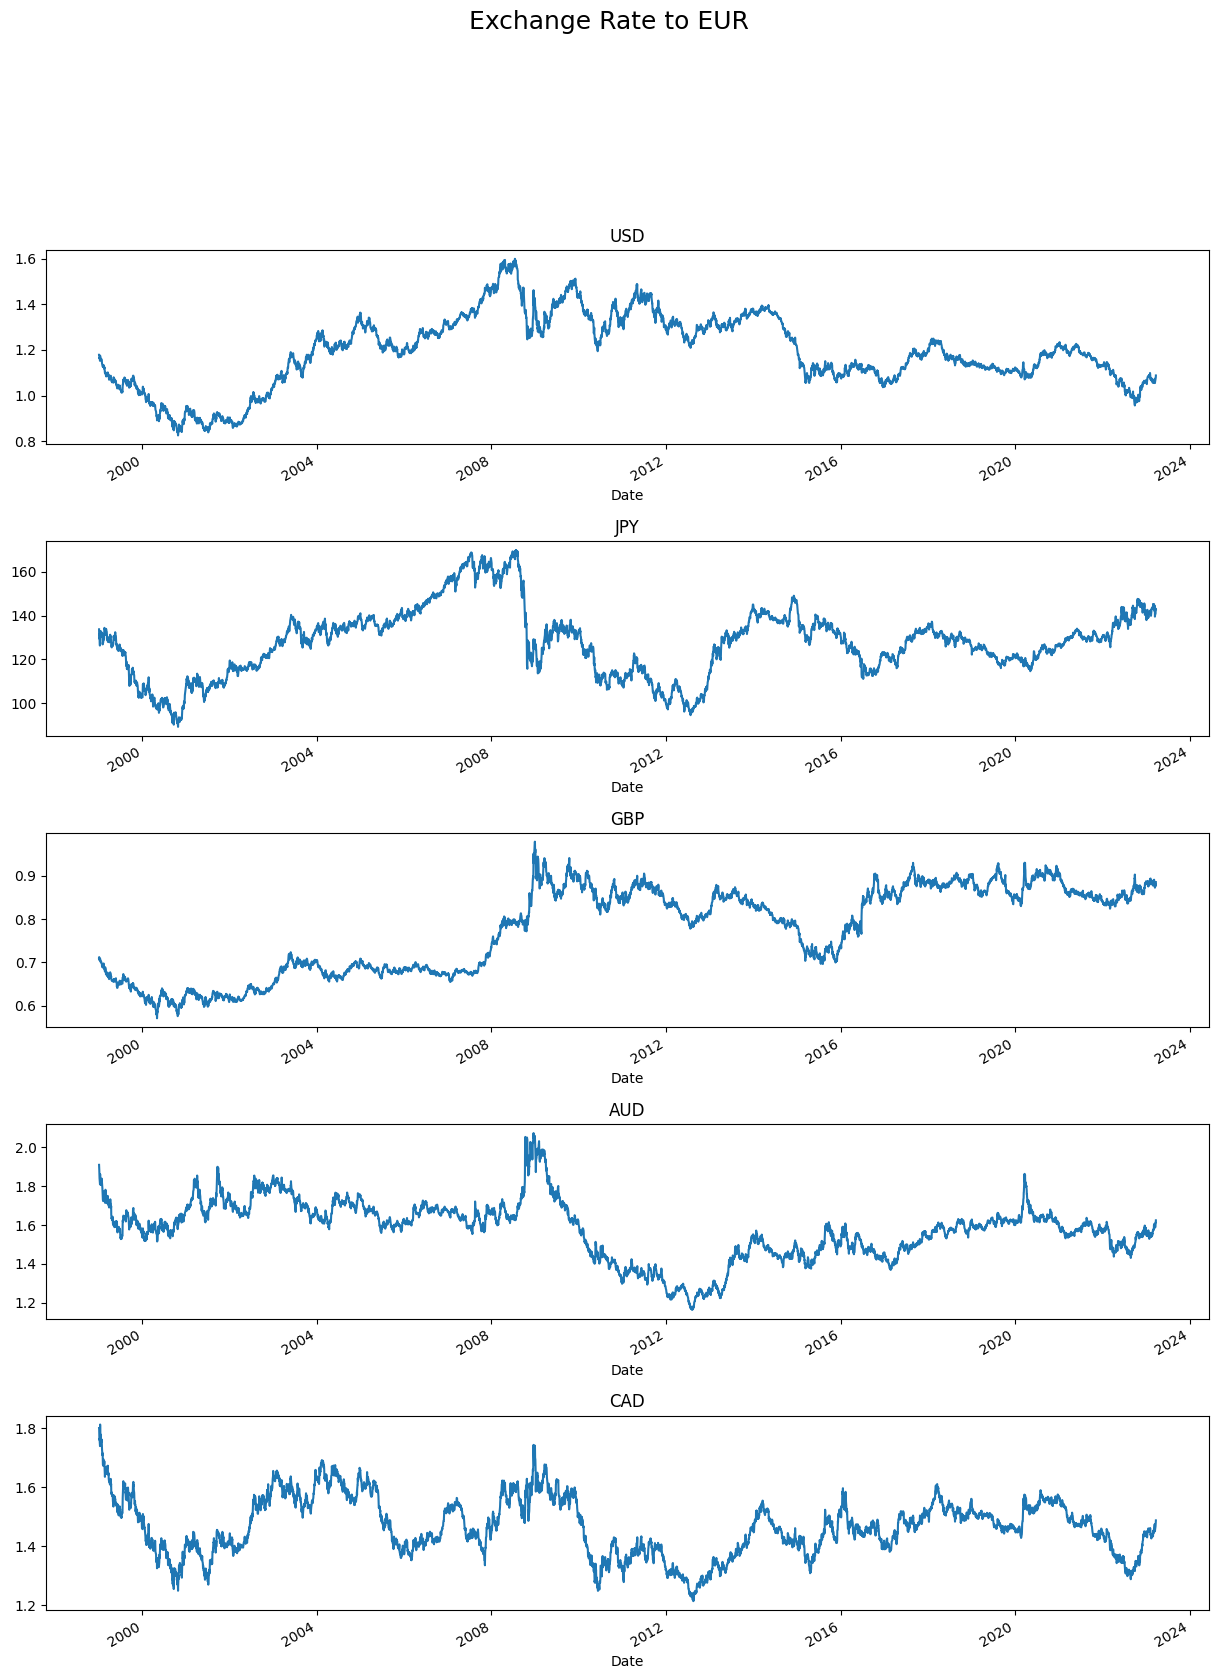

In [12]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Exchange Rate to EUR', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(df5_list):
    # add new subplot iteratively
    ax = plt.subplot(5,1,n+1)
    df5.plot(x='Date',y=currency,ax=ax, legend=None)
    # chart formating
    ax.set_title(currency.upper()) 

### Resample the data

Daily data for time series usually contains too much variation. Therefore, each series will be resampled by week. This resampled time series will be used to predict the exchange rate against the EUR.

Resampling the time series data based on weekly frequency <br>
Apply it on stock open price 'W' indicates week <br>
Find the mean exchange rate of each week <br>
For each week over the period 

In [13]:
weekly= pd.DataFrame()
weekly = df5.set_index('Date').resample('W', label='left').mean()  # label left for start date
pd.date_range(start='1999-01-03', end='2023-03-19', freq='W').difference(weekly.index)
weekly        

,USD,JPY,GBP,AUD,CAD
Date,,,,,
1999-01-03,1.172260,131.126,0.709230,1.87488,1.77850
1999-01-10,1.162240,130.466,0.705900,1.83170,1.76964
1999-01-17,1.158840,131.770,0.701100,1.82094,1.76252
1999-01-24,1.149780,132.032,0.695420,1.82740,1.74778
1999-01-31,1.131340,128.208,0.689920,1.76134,1.70138
...,...,...,...,...,...
2023-02-19,1.063360,143.392,0.881986,1.55536,1.43732
2023-02-26,1.061540,144.710,0.883326,1.57552,1.44322
2023-03-05,1.059920,144.614,0.887488,1.59632,1.45522


In [14]:
weekly.head()

,USD,JPY,GBP,AUD,CAD
Date,,,,,
1999-01-03,1.17226,131.126,0.70923,1.87488,1.77850
1999-01-10,1.16224,130.466,0.70590,1.83170,1.76964
1999-01-17,1.15884,131.770,0.70110,1.82094,1.76252
1999-01-24,1.14978,132.032,0.69542,1.82740,1.74778
1999-01-31,1.13134,128.208,0.68992,1.76134,1.70138


In [15]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.annotations import Title
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral10


source = ColumnDataSource(weekly)

output_notebook()

p = figure(plot_height = 500, \
           plot_width = 900, \
           x_axis_type = 'datetime')

p.line(x='Date', y='USD', legend_label = 'USD', source=source, color=Spectral10[1], line_width=4)
p.line(x='Date', y='JPY', legend_label = 'JPY', source=source, color=Spectral10[2], line_width=4)
p.line(x='Date', y='GBP', legend_label = 'GBP', source=source, color=Spectral10[3], line_width=4)
p.line(x='Date', y='AUD', legend_label = 'AUD', source=source, color=Spectral10[4], line_width=4)
p.line(x='Date', y='CAD', legend_label = 'CAD', source=source, color=Spectral10[5], line_width=4)


p.xaxis[0].ticker.desired_num_ticks = 20

p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Exchange Rate'

t = Title()
t.text = 'Exchange Rate: Top Countries/USD'
p.title = t

hover = HoverTool(tooltips = [
                  ('USD','@USD'),\
                  ('JPY', '@JPY'),\
                  ('GBP', '@GBP'),\
                  ('AUD', '@AUD'),\
                  ('CAD', '@CAD')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

## Stationarity Check

### Method 1: Perform the Augmented Dickey-Fuller (ADF)
We can alscheck for staionarity with statistical tests.

- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

The Dickey Fuller test is used to check the stationarity of the series. The test determines how stringly a time series is defined by a trend. The null hypothesis of the test is that time series is not stationary( has some time-dependent structure).<br>
The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If P-VALUE is less than the significance level , the null hypothesis is rejected and the series is stationary.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary.
The ADF tests give the following results – test statistic, p-value, and critical value at 1%, 5%, and 10% confidence intervals

The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If P-VALUE is less than the significance level , the null hypothesis is rejected and the series is stationary.

if p_value > 0.05 and the stat_value > any of the critical values:
* Acceptiong the Null Hypothesis i.e Dataset is Non-Stationary

else:
* Rejecting the Null Hypothesis i.e Dataset is Stationary

In [16]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [17]:
#Test whether the data is stationary to be able to use ARIMA model or not

#4.1 Stationary Testing using ADF Test
#H0: Dataset is not stationary
#H1: Dataset is stationary
for n, currency in enumerate(weekly): 
    print(currency)
    result = adfuller(weekly[currency].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  
        
    if result[1] > 0.05:
        print('Non-Stationary')
    else:
        print('Stationary')
    print('====================================')
        


USD
ADF Statistic: -1.827961
p-value: 0.366671
Critial Values:
   1%, -3.435550533536195
Critial Values:
   5%, -2.863836575823745
Critial Values:
   10%, -2.567992721718317
Non-Stationary
JPY
ADF Statistic: -2.139410
p-value: 0.228965
Critial Values:
   1%, -3.435554672689999
Critial Values:
   5%, -2.863838402102491
Critial Values:
   10%, -2.5679936943096284
Non-Stationary
GBP
ADF Statistic: -1.384464
p-value: 0.589701
Critial Values:
   1%, -3.435550533536195
Critial Values:
   5%, -2.863836575823745
Critial Values:
   10%, -2.567992721718317
Non-Stationary
AUD
ADF Statistic: -2.555162
p-value: 0.102623
Critial Values:
   1%, -3.435554672689999
Critial Values:
   5%, -2.863838402102491
Critial Values:
   10%, -2.5679936943096284
Non-Stationary
CAD
ADF Statistic: -4.086049
p-value: 0.001021
Critial Values:
   1%, -3.4355464009607255
Critial Values:
   5%, -2.8638347524449888
Critial Values:
   10%, -2.5679917506718044
Stationary


The Test Statistic is -1.840008, which is greater than any of the critical values.<br>
p-value is 0.360788 <br>
The p-value obtained is greater than the significance level of 0.05, and the ADF statistic is greater than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is, non-stationary.

Based on the obtained ADF statistic and p-value, it shows that the time series data_USD, JPY, GBP, AUD are non-stationary and CAN is staionary

### Method 2: ACF and PACF plots
ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

In [18]:
df_usd=weekly['USD']

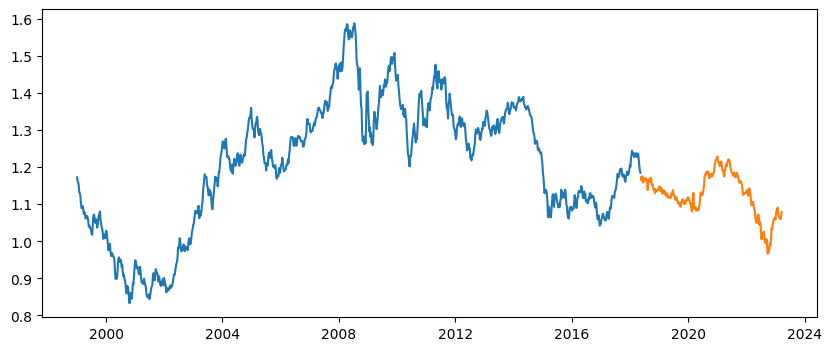

In [19]:
train_data, test_data = train_test_split(df_usd, test_size=0.2, shuffle=False)

plt.figure(figsize=(10, 4))
plt.plot(train_data)
plt.plot(test_data)

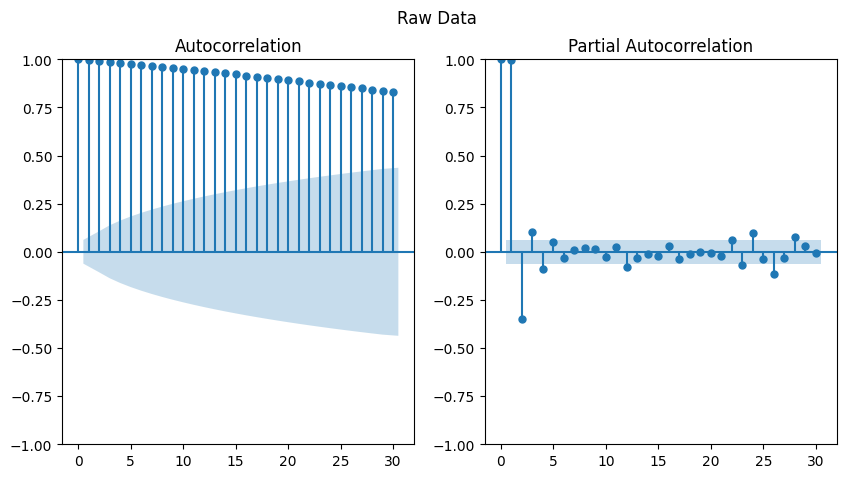

In [20]:
#ACF, PACF plot
#http://www.statmodels.org/stable/generated/statmodels.graghics.tsaplots.plot_acf.html
#http://www.statmodels.org/stable/generated/statmodels.graghics.tsaplots.plot_pacf.html

fig, ax=plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); #Modify not to generate graph twice

ACF plot이 점직적으로 낮아지는것은 nonstationary 데이타의 특성이다 
The ACF plot shows that the correlations with the legs are high and positive with very slow decay.
While the PACF plot shows the partial autocorrelations having a single spike at leg one.
These are both signs of a well-known time series called random walk which is not stationary.

### Seasonal decomposition plot: seasonal decomposition using movning averages.
- https://www.statsmodels.org/stable/generated/statsmodels.tsa/seasonal.seasonal_decompose.html
- bserved: observed data
- Trand: The estimated trend component
- seasonal: The estimated seasonal component
- resid : The The estimated residuals

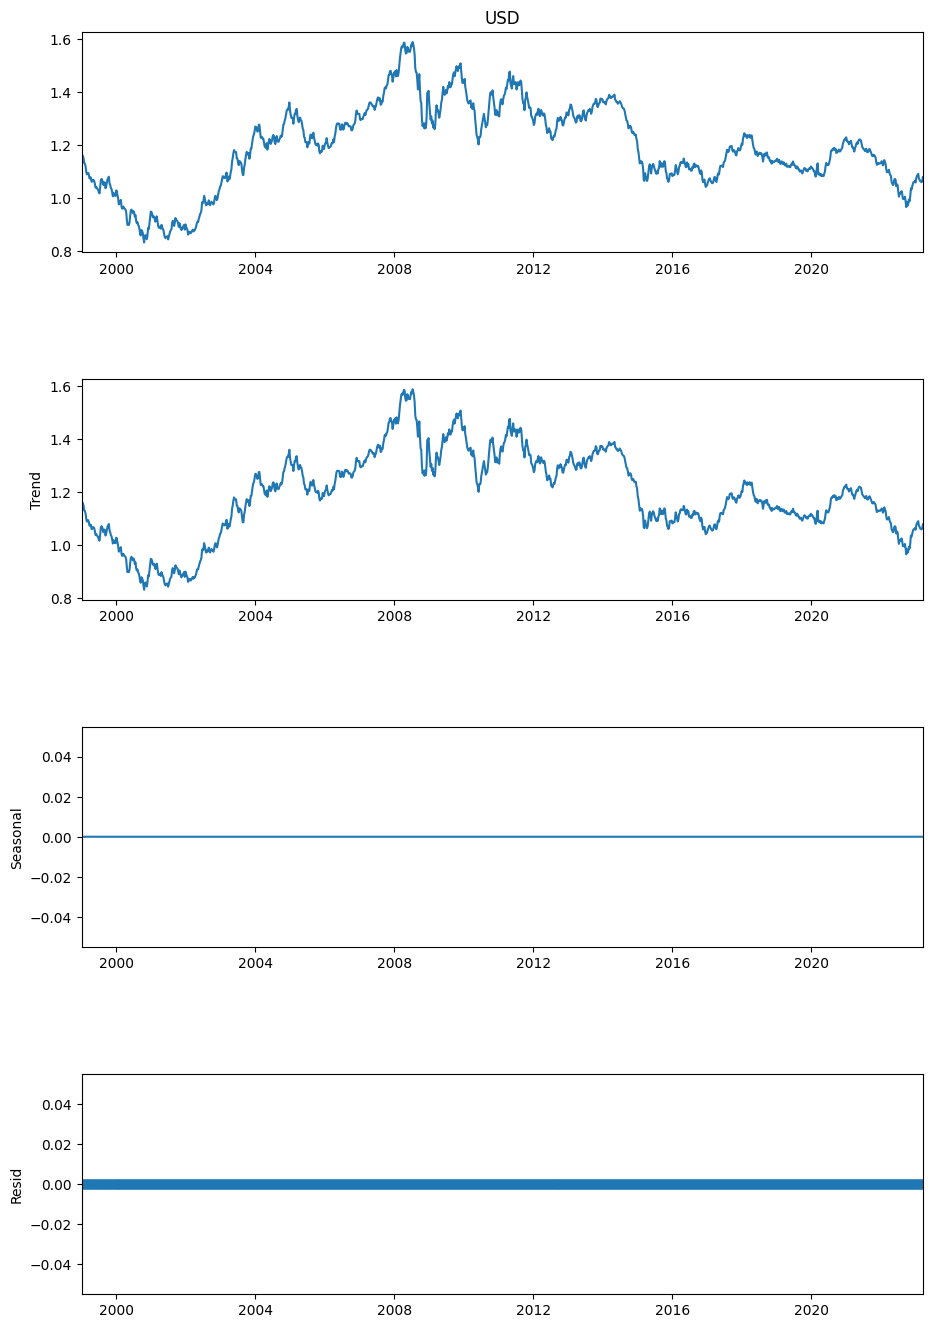

In [21]:
decompostion =sm.tsa.seasonal_decompose(df_usd, model='additive', period=1)
fig=decompostion.plot()
fig.set_size_inches(10,15)
plt.show()

Decompose the time series into its components such as trend, seasonality, and residuals to understand the different components that contribute to the overall behavior of the time series.

## Differenecing

If original series is nonstaintaionary, differencing might be needed.
Let's try it out on the training dataset and plot the new series,I use the current observation minus the previous observation to get the new series, also use the drop na method since the first observation has no previous observation to subtract so its difference is missing.

In [22]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.diff()
diff_train_data = diff_train_data.dropna() 

print('############# Raw Data ##############')
print(train_data)
print ('########### Differenced Data ###########')
print(diff_train_data)

############# Raw Data ##############
Date
1999-01-03    1.172260
1999-01-10    1.162240
1999-01-17    1.158840
1999-01-24    1.149780
1999-01-31    1.131340
                ...   
2018-04-15    1.236120
2018-04-22    1.217480
2018-04-29    1.201175
2018-05-06    1.189260
2018-05-13    1.184820
Freq: W-SUN, Name: USD, Length: 1011, dtype: float64
########### Differenced Data ###########
Date
1999-01-10   -0.010020
1999-01-17   -0.003400
1999-01-24   -0.009060
1999-01-31   -0.018440
1999-02-07   -0.001800
                ...   
2018-04-15    0.002340
2018-04-22   -0.018640
2018-04-29   -0.016305
2018-05-06   -0.011915
2018-05-13   -0.004440
Freq: W-SUN, Name: USD, Length: 1010, dtype: float64


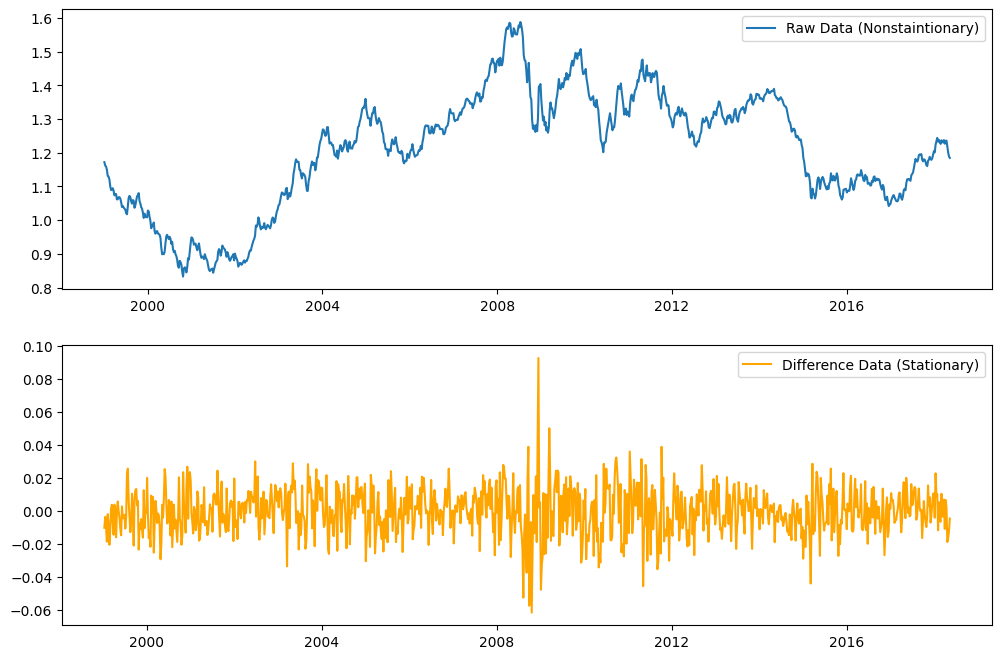

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data)
plt.legend(['Raw Data (Nonstaintionary)'])
plt. subplot(212)
plt.plot(diff_train_data,'orange') #first difference(t-(t-1))
plt.legend(['Difference Data (Stationary)'])
plt.show()

We can see the first difference time series doesn't show a strong trend anymore. It looks to be more stationary.

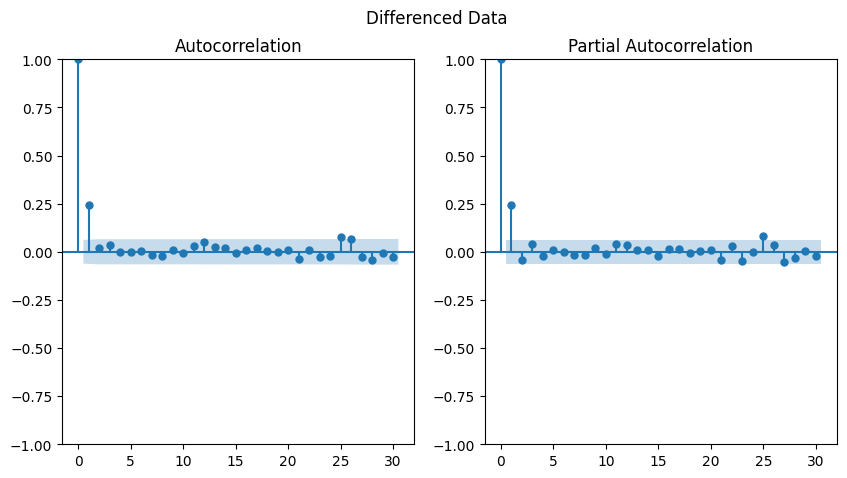

In [24]:
fig, ax=plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); 

### Parameter search
Python packages provide functions to fit ARIMA models automatically.  
Let's try pmd arima python package that offers automatic ARIMA modelling based on the stats model library. Start from the training set I have trained, obtained in step 0 when exploring the dataset.
The auto arima function can help us automate the steps to fit in arima model. It will generate the optimal model based on its criteria.

In [25]:
#pip install pmdarima

In [26]:
import pmdarima as pm
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

I set two of its parameters to be false so they will consider all possible, non-seasonal models.

In [27]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1011
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2915.842
Date:                Wed, 03 May 2023   AIC                          -5825.684
Time:                        20:05:48   BIC                          -5810.931
Sample:                    01-03-1999   HQIC                         -5820.080
                         - 05-13-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.495e-06      0.001      0.008      0.993      -0.001       0.001
ma.L1          0.2560      0.023     11.151      0.000       0.211       0.301
sigma2         0.0002   5.62e-06     32.341      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               214.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.08
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

By default the auto process uses unit root test to select the value of parameter d
Then uses AIC information criteria to determine the values of p and q

#### Best model:  ARIMA(0,1,1)(0,0,0)[0]  

### Use model to forecase - ARIMA

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

In [28]:
prediction, confint = auto_arima.predict(n_periods=len(test_data),return_conf_int=True )
prediction

2018-05-20    1.184274
2018-05-27    1.184279
2018-06-03    1.184283
2018-06-10    1.184288
2018-06-17    1.184292
                ...   
2023-02-19    1.185389
2023-02-26    1.185393
2023-03-05    1.185398
2023-03-12    1.185402
2023-03-19    1.185407
Freq: W-SUN, Length: 253, dtype: float64

In [29]:
cf= pd.DataFrame(confint)

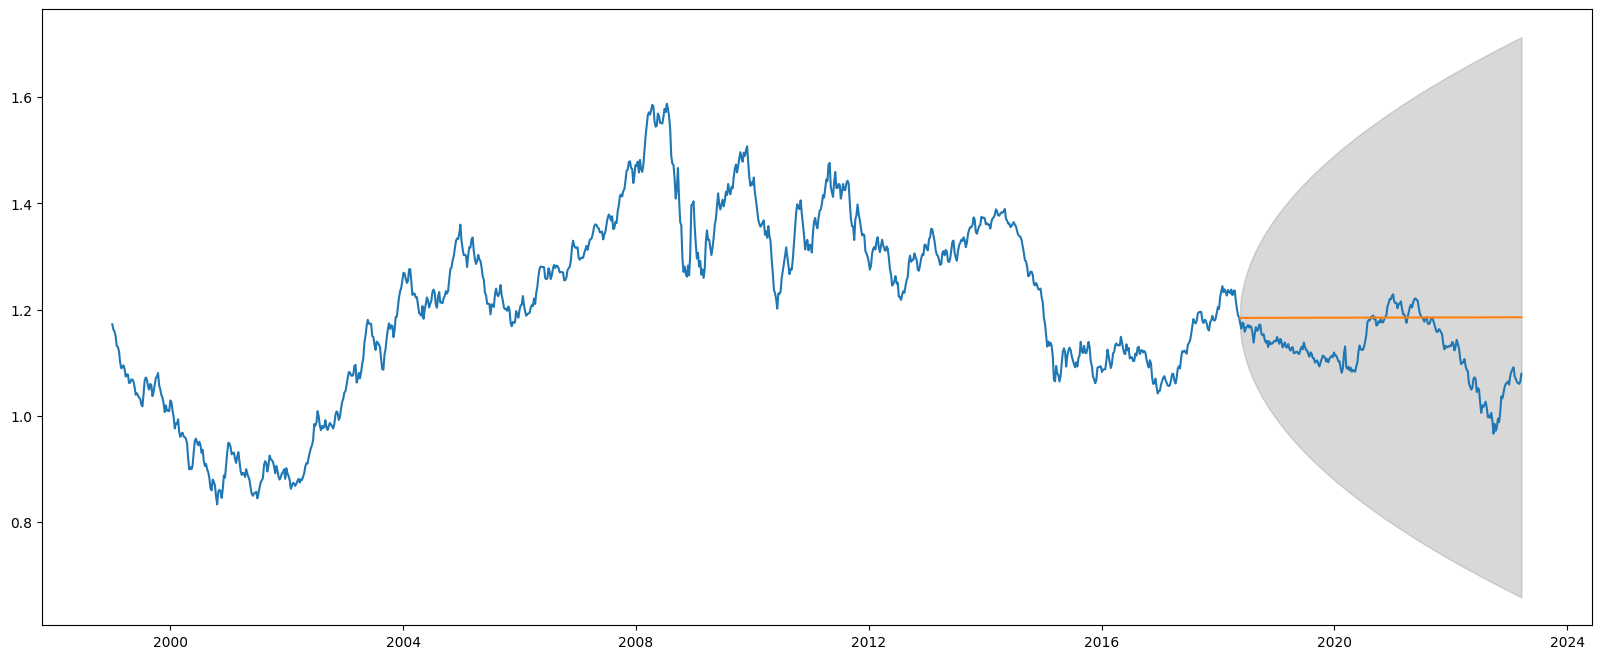

In [30]:
prediction_series = pd.Series(prediction,index=test_data.index)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(weekly['USD'])
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [31]:
prediction_series.index[0]

Timestamp('2018-05-20 00:00:00', freq='W-SUN')

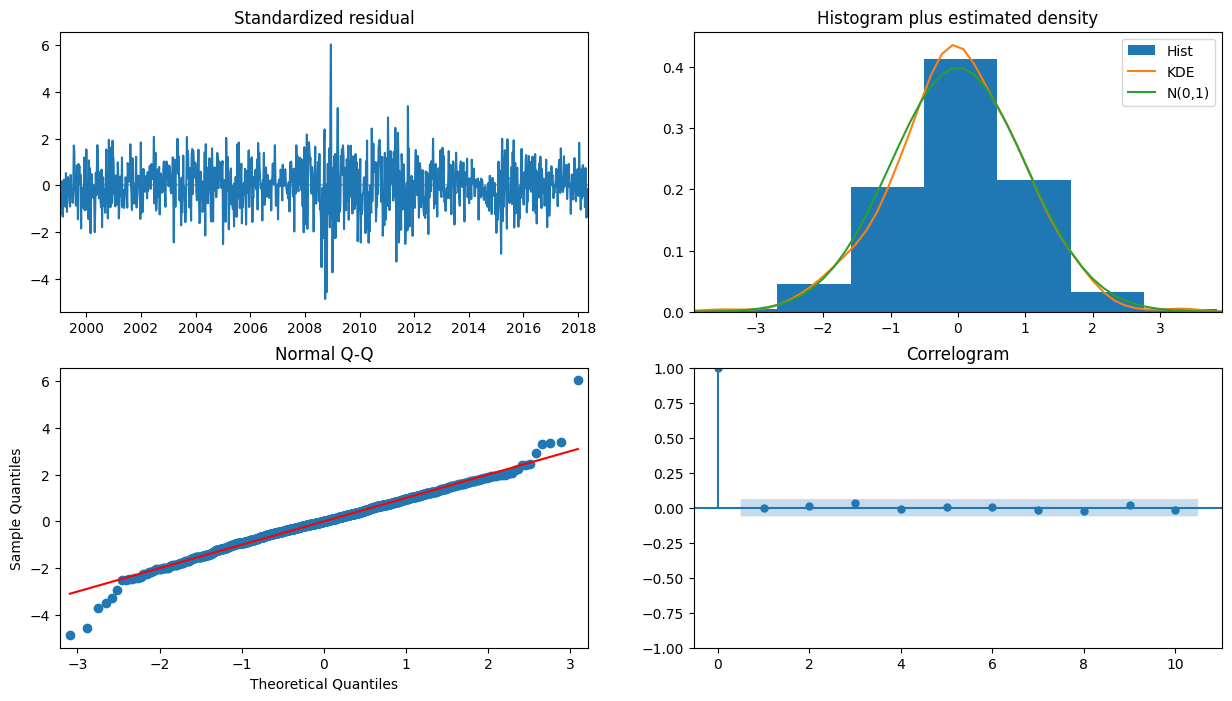

In [32]:
auto_arima.plot_diagnostics(figsize=(15,8))
plt.show()

The residuals look random in general and the density looks normally distributed with a mean of around 0
The plots show that the residuals are not correlated. The standardised residuals model seems similar to the previous one but as we have seen in the model summary this model is more reliable because we can't reject the null hypothesis of homoscedasticity (constant variance).

Let's calculate the SMAPE (Symmetric Mean Absolute Error)

As we have seen in the notebook the results are slightly different than in the original attempt. The parameters selAs we can see from the notebook, the results differ slightly from the first attempt. The parameters chosen by auto-arima differ. The results are very similar, though slightly worse with the auto-arima model, as evidenced by the SMAPE metric.

Again, the 3-year prediction produces a higher SMAPE value, but the heteroscedasticity test reveals that this model does not account for all of the variance in the data. The 1-year prediction is more reliable because it meets all of the conditions in a valid ARIMA model (non-correlation and constant variance in the residuals).

This has been a really interesting project that has helped me better understand how ARIMA works and how to handle real-world data in order to make a prediction.

### Evaluate model predictions

To evaluate the fitting by ARIMA, we have used the below metrics:

Mean Squared Error (MSE): MSE measures the average squared difference between the predicted and actual values of a time series. A lower MSE value indicates better performance. The formula for MSE is: MSE = (1/n) * Σ(actual_i - predicted_i)^2 where n is the number of observations in the time series, actual_i is the actual value of the i-th observation, and predicted_i is the predicted value of the i-th observation.

Root Mean Squared Error (RMSE): RMSE is the square root of the MSE, and it measures the average distance between the predicted and actual values of a time series. Like MSE, a lower RMSE value indicates better performance. The formula for RMSE is: RMSE = sqrt((1/n) * Σ(actual_i - predicted_i)^2)

Mean Absolute Error (MAE): MAE measures the average absolute difference between the predicted and actual values of a time series. It is less sensitive to outliers than MSE and RMSE. The formula for MAE is: MAE = (1/n) * Σ|actual_i - predicted_i|

Mean Absolute Percentage Error (MAPE): MAPE measures the average percentage difference between the predicted and actual values of a time series. It is often used to evaluate the accuracy of forecasting models. The formula for MAPE is: MAPE = (1/n) * Σ|(actual_i - predicted_i)/actual_i|

These metrics are commonly used to evaluate the performance of ARIMA models.

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [34]:
mse = mean_squared_error(test_data, prediction_series)
mae = mean_absolute_error(test_data, prediction_series)
mape = mean_absolute_percentage_error(test_data, prediction_series)
rmse = np.sqrt(mean_squared_error(test_data, prediction_series))
accuracy = (1-mape)*100

In [35]:
print(f'mse: {mse}')           
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')      
print(f'accuracy: {accuracy}')      

mse: 0.00669309147995372
mae: 0.06445269982170501
mape: 0.05965615910051278
rmse: 0.08181131633187257
accuracy: 94.03438408994872
